In [1]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import random

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
import random

C:\Users\bartekb\AppData\Local\Temp\ipykernel_6256\801772378.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import re
# pip install nltk
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
spotify_df = pd.read_csv('../Data/spotify_modelling.csv')
spotify_df.head(10) 

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,You Proof,Morgan Wallen,1,2022,5,13,2128,9,367814306,37,...,120,A,Major,73,64,85,25,0,61,3
1,Adore You,Harry Styles,1,2019,12,6,13454,1,1439191367,246,...,99,G#,Major,68,57,77,2,0,10,5
2,Piï¿½ï¿½man Deï¿,"Semicenk, Doï¿½ï¿½u",2,2023,6,2,185,3,43522589,5,...,98,A#,Minor,73,45,62,28,0,13,13
3,CORAZï¿½ï¿½N VA,Maria Becerra,1,2023,6,22,370,20,43857627,12,...,98,C#,Major,68,40,79,33,0,30,6
4,Those Eyes,New West,1,2019,5,10,1507,14,411747614,24,...,120,E,Major,60,24,35,73,0,31,3
5,Crown,Kendrick Lamar,1,2022,5,13,1493,0,42485571,2,...,170,C#,Minor,37,14,24,80,0,11,4
6,HUMBLE.,Kendrick Lamar,1,2017,3,30,33206,1,1929770265,284,...,150,C#,Minor,91,42,60,0,0,9,12
7,I Know - PR1SVX Edit,"Kanii, PR1ISVX",2,2023,3,24,407,0,77377503,16,...,134,B,Minor,67,11,76,8,47,30,7
8,Levitating (feat. DaBaby),"Dua Lipa, DaBaby",2,2020,3,27,15894,8,1802514301,198,...,103,F#,Minor,70,92,83,1,0,7,6
9,DOGTOOTH,"Tyler, The Creator",2,2023,3,27,1479,0,80758350,23,...,78,G#,Major,71,80,65,51,0,22,32


# 1. Feature engineering

In [4]:
# handle incorrect values

spotify_df.at[497, 'streams'] = None
spotify_df['streams'] = spotify_df['streams'].astype(float)
print(spotify_df['streams'].mean())
spotify_df['streams'].fillna(524376116,inplace=True)

spotify_df['in_deezer_playlists'] = spotify_df['in_deezer_playlists'].str.replace(',', '', regex=False)
spotify_df['in_deezer_playlists'] = spotify_df['in_deezer_playlists'].astype(int)

spotify_df['in_shazam_charts'] = spotify_df['in_shazam_charts'].str.replace(',', '', regex=False)
spotify_df['in_shazam_charts'] = spotify_df['in_shazam_charts'].astype(float)


524376116.6216216


## Categorical variables

In [5]:
numeric = ['in_shazam_charts','in_deezer_charts','in_deezer_playlists','in_apple_charts','in_apple_playlists','streams','in_spotify_charts','in_spotify_playlists','bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
categorical = list(set(spotify_df.columns) - set(numeric))
categorical

['artist(s)_name',
 'key',
 'released_year',
 'mode',
 'track_name',
 'released_month',
 'artist_count',
 'released_day']

### Plan:
- ordinal encoding for **key** column
- binary encode **mode**
- try cyclical encoding of **released_month** and **released_day**
- try grouping and ordinal encoding **released_year**
- decide about **artist(s)_name** and **track_name**



### key 

We use ordinal encoding for the 'key' column because musical keys have a natural order based on their pitch, which is important for preserving the inherent relationships between them in musical theory. The chosen order reflects the sequence of keys in a chromatic scale, ensuring that the encoding respects the progression from one key to the next in terms of pitch.

In [6]:
spotify_df.key.unique()

array(['A', 'G#', 'A#', 'C#', 'E', 'B', 'F#', 'D', nan, 'F', 'D#', 'G'],
      dtype=object)

In [7]:
spotify_df.key.nunique()

11

In [8]:

key_order = [
    'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan
]
ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
spotify_df['key'] = spotify_df['key'].astype(object)
encoded_keys = ordinal_encoder.fit_transform(spotify_df[['key']])
spotify_df['key'] = encoded_keys
#fill missing valeus with most common value
spotify_df['key'].fillna(-1, inplace=True)


In [9]:
spotify_df['key'].head(10)

0     9.0
1     8.0
2    10.0
3     1.0
4     4.0
5     1.0
6     1.0
7    11.0
8     6.0
9     8.0
Name: key, dtype: float64

### mode

In [10]:
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Major', 'Minor'])
spotify_df['mode'] = label_encoder.fit_transform(spotify_df['mode'])

In [11]:
spotify_df['mode'].head(10)

0    0
1    0
2    1
3    0
4    0
5    1
6    1
7    1
8    1
9    0
Name: mode, dtype: int32

### released_month and released_day

since we are trying to recommend music and in eda we found no correlation between these variables and others we decided to removve these columns

In [12]:
spotify_df.drop(columns=['released_month','released_day'],axis='columns',inplace=True)
#spotify_df['month_sin'] = np.sin(2 * np.pi * spotify_df['released_month'] / 12)
#spotify_df['day_sin'] = np.sin(2 * np.pi * spotify_df['released_day'] / 31)

### released_year

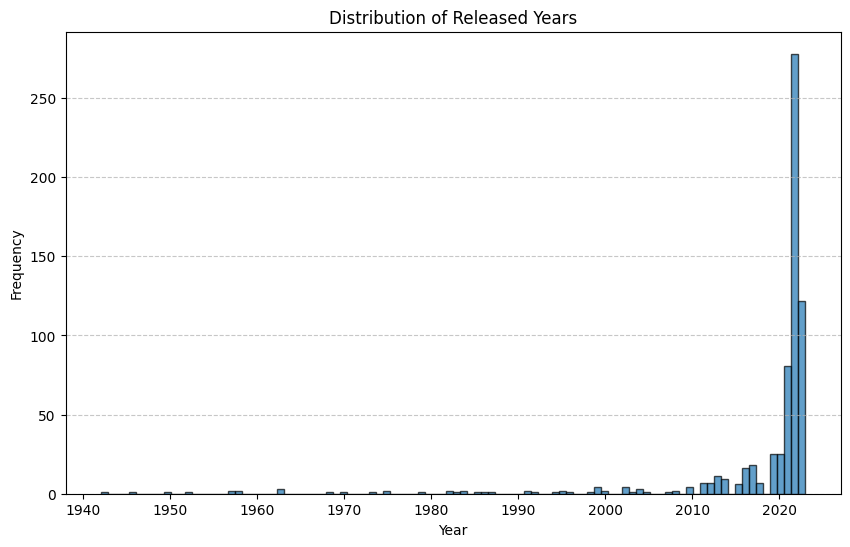

2023
1942


In [13]:
plt.figure(figsize=(10, 6))
plt.hist(spotify_df['released_year'],bins=100, edgecolor='k', alpha=0.7)
plt.title('Distribution of Released Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(max(spotify_df.released_year))
print(min(spotify_df.released_year))

considering histogram above ands trends in music, we will try grouping released_year in intervals:
- [1942 , 1989]
- [1990 , 1999]
- [2000 , 2010]
- [2011 , 2015]
- [2016, 2019]
- 2020
- 2021
- 2022
- 2023

In [14]:
bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
labels = ['1942-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']

spotify_df['year_group'] = pd.cut(spotify_df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)

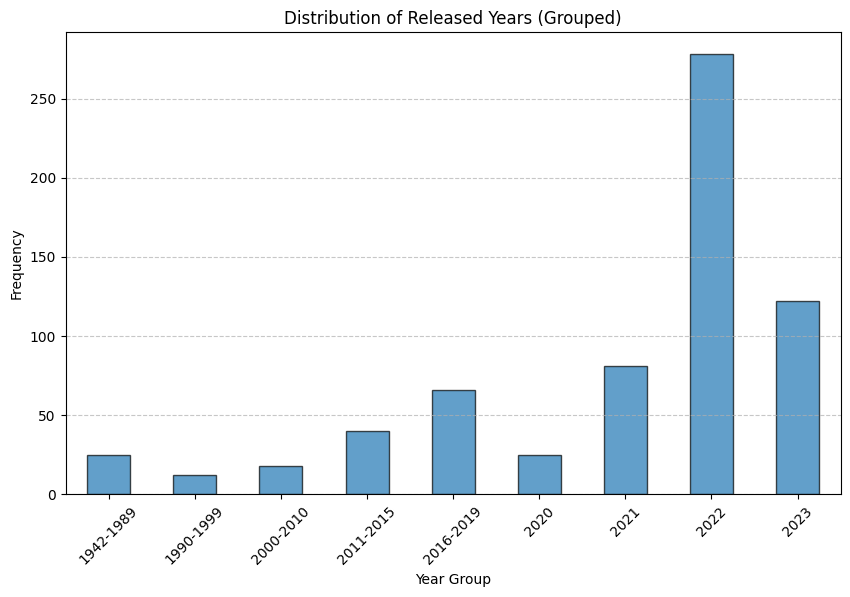

In [15]:
plt.figure(figsize=(10, 6))
spotify_df['year_group'].value_counts().sort_index().plot(kind='bar', edgecolor='k', alpha=0.7)
plt.title('Distribution of Released Years (Grouped)')
plt.xlabel('Year Group')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [16]:
ordinal_mapping = {label: idx for idx, label in enumerate(labels)}

spotify_df['year_group_encoded'] = spotify_df['year_group'].map(ordinal_mapping)


### Track Name

By simply encoding this variable we will not achieve anything, since almost all songs have different title. We can try to extract keywords, determining what the song is about and label it that way


In [17]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'\W+', ' ', text) 
    tokens = word_tokenize(text) 
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

spotify_df['processed_track_name'] = spotify_df['track_name'].apply(preprocess_text)

In [18]:
# keywords and song topics generated by chatgpt
topics = {
    'love': ['love', 'romance', 'heart', 'passion', 'affection', 'relationship', 'sweetheart', 'devotion', 'together', 'kiss', 'couples', 'embrace', 'intimacy', 'wedding', 'romantic', 'admiration', 'adoration', 'infatuation', 'commitment', 'tenderness', 'butterflies', 'endearment', 'cherish', 'loyalty', 'soulmate', 'chemistry', 'courtship', 'truelove', 'warmth'],
    'party': ['party', 'dance', 'club', 'celebration', 'night', 'fun', 'music', 'drink', 'friends', 'good time', 'festive', 'cheer', 'groove', 'get-together', 'rave', 'excitement', 'festivity', 'socialize', 'entertainment', 'vibrant', 'fest', 'revelry', 'beats', 'livelihood', 'festive', 'boogie', 'festivity', 'festival', 'soiree'],
    'sad': ['sad', 'tears', 'cry', 'heartbreak', 'pain', 'lonely', 'hurt', 'grief', 'sorrow', 'loss', 'melancholy', 'despair', 'depression', 'mourning', 'suffering', 'anguish', 'desolation', 'regret', 'misery', 'despondency', 'heartache', 'anguish', 'downhearted', 'bereavement', 'wretched', 'woeful', 'pained', 'lament', 'dejected'],
    'nostalgia': ['memory', 'old', 'past', 'nostalgia', 'remember', 'youth', 'reminisce', 'nostalgic', 'childhood', 'memories', 'retro', 'vintage', 'recollection', 'flashback', 'sentimental', 'heritage', 'heritage', 'retrospect', 'antique', 'reminiscence', 'recapture', 'revisit', 'reflective', 'yesteryears', 'timeless', 'nostalgic', 'nostalgic', 'reminiscing', 'revive'],
    'adventure': ['road', 'travel', 'journey', 'explore', 'discovery', 'wanderlust', 'adventure', 'expedition', 'voyage', 'explore', 'explorer', 'quest', 'odyssey', 'wandering', 'discover', 'excursion', 'quest', 'wander', 'pioneering', 'trek', 'jaunt', 'sojourn', 'venture', 'venture', 'traverse', 'roam', 'peripatetic', 'roving', 'excursion'],
    'inspirational': ['inspiration', 'motivation', 'uplifting', 'hope', 'encouragement', 'empowerment', 'dream', 'aspiration', 'positivity', 'strength', 'inspire', 'encourage', 'empower', 'perseverance', 'achievement', 'insightful', 'encouraging', 'empowering', 'inspirational', 'uplift', 'invigorate', 'revitalize', 'energize', 'empowering', 'motivate', 'upliftment', 'optimistic', 'enthusiastic', 'motivated'],
    'nature': ['nature', 'earth', 'sky', 'ocean', 'forest', 'mountain', 'wildlife', 'scenery', 'landscape', 'environment', 'natural', 'outdoors', 'ecology', 'wilderness', 'flora', 'fauna', 'terrain', 'scenic', 'serene', 'biodiversity', 'countryside', 'greenery', 'botanical', 'biological', 'zenith', 'wild', 'lush', 'serenity'],
    'reflection': ['reflection', 'contemplation', 'introspection', 'meditation', 'thought', 'ponder', 'ruminate', 'consider', 'analyze', 'evaluate', 'philosophy', 'self-awareness', 'introspective', 'pondering', 'self-reflection', 'thoughtful', 'contemplative', 'analytical', 'introspective', 'deliberate', 'self-examination', 'speculate', 'mull', 'think', 'deliberation', 'reflection', 'introspection'],
    'dream': ['dream', 'fantasy', 'imagination', 'wish', 'vision', 'desire', 'goal', 'ideal', 'ambition', 'fantasize', 'daydream', 'whimsical', 'fanciful', 'dreamer', 'dreamland', 'visionary', 'creative', 'imaginative', 'idealistic', 'aspiration', 'dreamlike', 'dreamworld', 'dreamer', 'dreamy', 'dreamscape', 'imaginative', 'vision', 'utopia'],
    'hope': ['hope', 'optimism', 'faith', 'belief', 'trust', 'confidence', 'promise', 'reassurance', 'expectation', 'anticipation', 'optimistic', 'faithful', 'reliable', 'hopeful', 'assurance', 'reliance', 'positive', 'faith', 'expectant', 'confidence', 'assurance', 'reassure', 'hopefulness', 'positive', 'assure', 'faith', 'optimism', 'confidence']
}


In [19]:
def determine_topic(tokens):
    topic_scores = {topic: 0 for topic in topics}
    for word in tokens:
        for topic, keywords in topics.items():
            if word in keywords:
                topic_scores[topic] += 1
    max_score = max(topic_scores.values())
    if max_score == 0:
        return 'other'
    else:
        return max(topic_scores, key=topic_scores.get)

spotify_df['topic'] = spotify_df['processed_track_name'].apply(determine_topic)

artist names - the idea to solve the problem is to assign song to the most popular collaborator. Encoding this variable is another problem because there are a lot of unique values, so one hot encoding may not be suitable and there is no ordinality in this variable so label encoding is also not really good in this case. We can try to group this variable by popularity of most popular author and label encode it. 

In [20]:
# function to make dictionary of artists popularity by avg value of streams column. This step should be done on modelling dataset 
# and this dictionary should be used on validating dataset
def split_artists(df, artist_col='artist(s)_name'):
    df_expanded = df.copy()
    df_expanded[artist_col] = df_expanded[artist_col].str.split(',')
    df_expanded = df_expanded.explode(artist_col)
    df_expanded[artist_col] = df_expanded[artist_col].str.lower().str.replace(' ', '')
    return df_expanded.reset_index(drop=True)
def calculate_mean_streams(df, artist_col='artist(s)_name', streams_col='streams'):
    mean_streams = df.groupby(artist_col)[streams_col].mean()
    return mean_streams.to_dict()

In [21]:
popularity = calculate_mean_streams(split_artists(spotify_df))

In [22]:
popularity

{'': 187772591.0,
 '(g)i-dle': 133491665.0,
 '070shake': 358322553.0,
 '21savage': 290919837.72727275,
 '24kgoldn': 1699402402.0,
 '2pac': 579395142.0,
 '347aidan': 160845341.0,
 '50cent': 1202722675.0,
 'a$aprocky': 94186466.0,
 'abhirhathi': 245400167.0,
 'aboogiewitdahoodie': 109276132.0,
 'acraze': 674772936.0,
 'adele': 1439455583.5,
 'aerosmith': 838586769.0,
 'agroplay': 233801632.0,
 'agustd': 118810253.0,
 'aitch': 146223492.0,
 'ak4:20': 118381354.0,
 'alecbenjamin': 1374581173.0,
 'alejo': 273005485.0,
 'alesso': 226897599.0,
 'aliciakeys': 107255472.0,
 'alisethi': 284249832.0,
 'alvarodiaz': 209768491.0,
 'amaarae': 354065229.0,
 'amandareifer': 237351106.0,
 'amitabhbhattacharya': 366599607.0,
 'anacastela': 229709441.0,
 'anderson.paak': 749715500.0,
 'andywilliams': 663832097.0,
 'angelaaguilar': 236857112.0,
 'anggimarito': 179659294.0,
 'anitta': 333690160.5,
 'anne-marie': 177740666.0,
 'annenmaykantereit': 236872197.0,
 'anuelaa': 288498523.0,
 'apdhillon': 32749803

In [23]:
sorted_popularity = dict(sorted(popularity.items(), key=lambda item: item[1], reverse=True))
sorted_popularity

{'kyla': 2713922350.0,
 'glassanimals': 2557975762.0,
 'thechainsmokers': 2397652496.0,
 'queen': 2197010679.0,
 'bradleycooper': 2159346687.0,
 'hozier': 2135158446.0,
 'vancejoy': 2009094673.0,
 'avicii': 1970673297.0,
 'macklemore': 1953533826.0,
 'raydalton': 1953533826.0,
 'ryanlewis': 1953533826.0,
 'thekillers': 1806617704.0,
 'dababy': 1802514301.0,
 'daftpunk': 1749672653.0,
 'theneighbourhood': 1705119866.5,
 '24kgoldn': 1699402402.0,
 'ianndior': 1699402402.0,
 'natedogg': 1695712020.0,
 'linkinpark': 1624165576.0,
 'imaginedragons': 1623991449.75,
 'maroon5': 1619416234.0,
 'samsmith': 1606986953.0,
 'pnau': 1605224506.0,
 'thepolice': 1593270737.0,
 "gunsn'roses": 1553497987.0,
 'onerepublic': 1548574801.5,
 'lilnasx': 1490196242.6666667,
 'wizkhalifa': 1479264469.0,
 'gotye': 1457139296.0,
 'kimbra': 1457139296.0,
 'mariahcarey': 1449779435.0,
 'danielcaesar': 1445941661.0,
 'adele': 1439455583.5,
 'lordhuron': 1410088830.0,
 'arcticmonkeys': 1392451682.75,
 'alecbenjamin

In [24]:
#function to assign song to most popular artist 
def process_artists(df, artist_avg_streams, artist_col='artist(s)_name', artist_count_col='artist_count'):
    def get_top_artist(artists, artist_avg_streams):
        artists = [artist.lower().replace(' ', '') for artist in artists]
        valid_artists = [artist for artist in artists if artist in artist_avg_streams]
        if valid_artists:
            top_artist = max(valid_artists, key=lambda artist: artist_avg_streams[artist])
        else:
            top_artist = random.choice(artists)
        return top_artist
    processed_df = df.copy()
    for i, row in processed_df.iterrows():
        artists = row[artist_col].split(',')
        top_artist = get_top_artist(artists, artist_avg_streams)
        processed_df.at[i, artist_col] = top_artist
            
    return processed_df

In [25]:
spotify_df = process_artists(spotify_df,popularity)
spotify_df[spotify_df['artist(s)_name'].str.contains('kanye', case=False, na=False)]

,track_name,artist(s)_name,artist_count,released_year,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,year_group,year_group_encoded,processed_track_name,topic
27,Heartless,kanyewest,1,2008,17504,34,887906111.0,63,39,1315,...,66,65,5,0,25,14,2000-2010,2,[heartless],other
349,City of Gods,kanyewest,3,2022,2096,0,107255472.0,34,3,30,...,50,80,10,0,32,38,2022,7,"[city, gods]",other
618,Hot Shit (feat. Ye & Lil Durk),kanyewest,3,2022,1601,0,85924992.0,11,0,2,...,52,69,0,0,8,23,2022,7,"[hot, shit, feat, ye, lil, durk]",other


In [26]:
print(len(spotify_df['artist(s)_name'].unique()))

342


In [27]:
# function to group artists of songs by popularity
def assign_artist_popularity(df, artist_avg_streams, artist_col='artist(s)_name'):
    # Calculate the four quantiles for the dictionary values
    quantiles = pd.qcut(list(artist_avg_streams.values()), 4, labels=False, retbins=True)[1]
    
    # Function to assign popularity based on quantiles
    def get_popularity(artist, artist_avg_streams, quantiles):
        artist = artist.lower().replace(' ', '')
        avg_streams = artist_avg_streams.get(artist, None)
        if avg_streams is not None:
            if avg_streams <= quantiles[1]:
                return 1
            elif avg_streams <= quantiles[2]:
                return 2
            elif avg_streams <= quantiles[3]:
                return 3
            else:
                return 4
        else:
            return 1  # Assign 1 if artist is not in the dictionary
    
    # Create a new column 'artist_popularity' and assign values based on quantiles
    df['artist_popularity'] = df[artist_col].apply(lambda artist: get_popularity(artist, artist_avg_streams, quantiles))
    
    return df

In [28]:
assign_artist_popularity(spotify_df,popularity)
spotify_df[['artist(s)_name','artist_popularity']]

,artist(s)_name,artist_popularity
0,morganwallen,1
1,harrystyles,4
2,semicenk,1
3,mariabecerra,3
4,newwest,3
...,...,...
662,pnau,4
663,taylorswift,3
664,keisyalevronka,2
665,hotelugly,2


## Numeric variables

In [29]:
numeric

['in_shazam_charts',
 'in_deezer_charts',
 'in_deezer_playlists',
 'in_apple_charts',
 'in_apple_playlists',
 'streams',
 'in_spotify_charts',
 'in_spotify_playlists',
 'bpm',
 'danceability_%',
 'valence_%',
 'energy_%',
 'acousticness_%',
 'instrumentalness_%',
 'liveness_%',
 'speechiness_%']

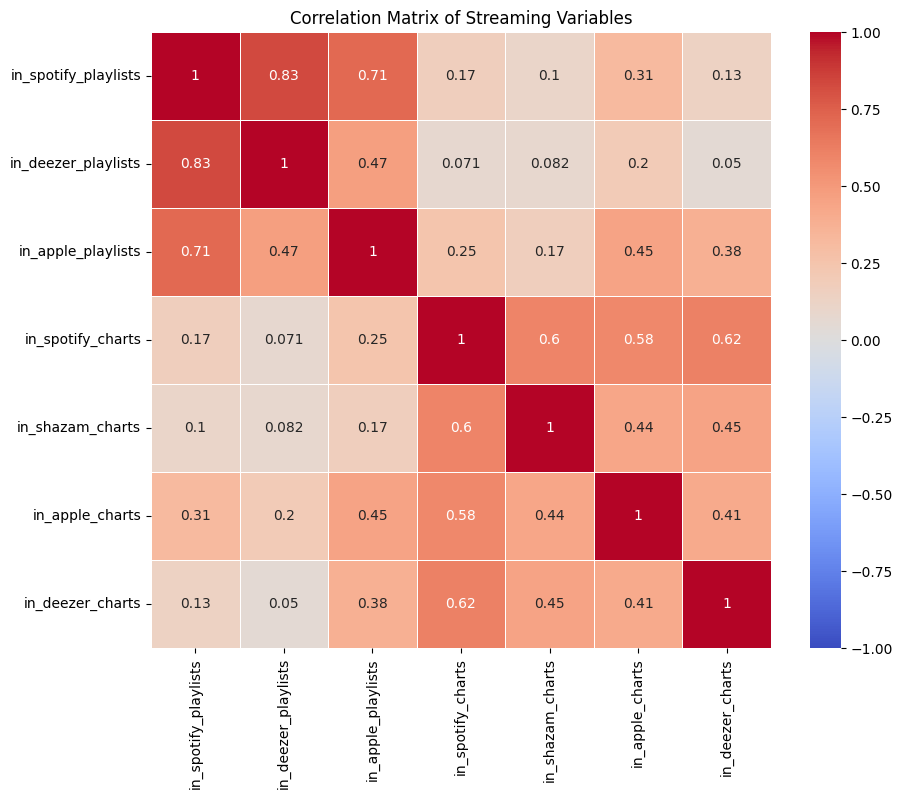

In [30]:
correlation_matrix = spotify_df[['in_spotify_playlists', 'in_deezer_playlists', 'in_apple_playlists','in_spotify_charts','in_shazam_charts', 'in_apple_charts', 'in_deezer_charts']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5,vmin=-1,vmax=1)
plt.title('Correlation Matrix of Streaming Variables')
plt.show()

variables: in_spotify_charts in_apple_charts and in_deezer_charts are strongly correlated so we decide to leave only in_spotify_charts.
from in_spotify_playlists and in_deezer_playlists we decide to delete in_apple_playlists and in_deezer_playlists

In [31]:
spotify_df.drop(columns=['in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists'],axis='columns',inplace=True)

### normalize other numeric variables

In [32]:
cols_to_normalize =['streams',
 'in_spotify_charts',
 'in_spotify_playlists',
 'bpm',
 'danceability_%',
 'valence_%',
 'energy_%',
 'acousticness_%',
 'instrumentalness_%',
 'liveness_%',
 'speechiness_%']


scaler = MinMaxScaler()
spotify_df[cols_to_normalize] = scaler.fit_transform(spotify_df[cols_to_normalize])

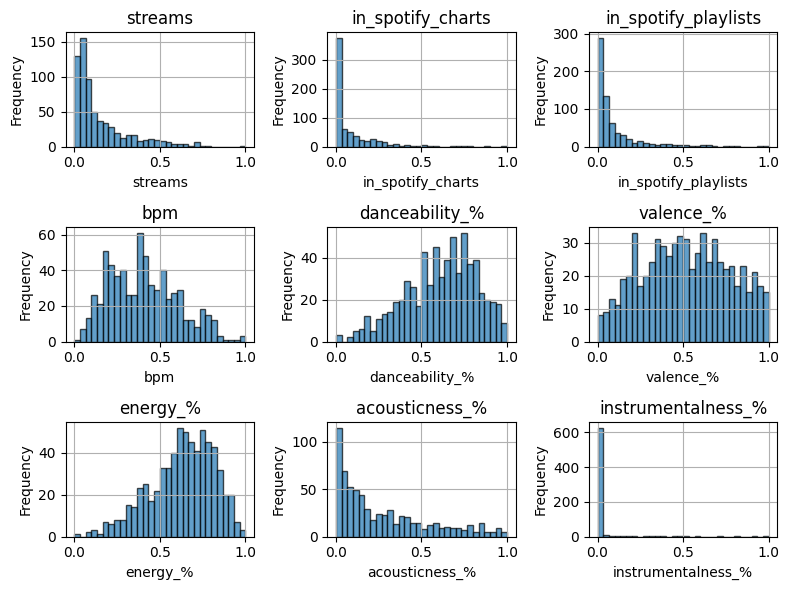

In [33]:
num_cols = len(cols_to_normalize)
num_rows = (num_cols + 3) // 4  # Zakładając 3 kolumny w każdym rzędzie

fig, axes = plt.subplots(num_rows, 3, figsize=(8, 2 * num_rows))

for ax, col in zip(axes.flat, cols_to_normalize):
    ax.hist(spotify_df[col], bins=30, edgecolor='k', alpha=0.7)
    ax.set_title(f'{col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

### normalizing key, year_group_encoded and artist_popularity

In [34]:
scaler = MinMaxScaler()
columns_to_scale = ["key", "year_group_encoded", "artist_popularity"]
spotify_df[columns_to_scale] = scaler.fit_transform(spotify_df[columns_to_scale])

In [35]:
spotify_df[["key", "year_group_encoded", "artist_popularity"]].head(10)


,key,year_group_encoded,artist_popularity
0,0.833333,0.875,0.000000
1,0.750000,0.500,1.000000
2,0.916667,1.000,0.000000
3,0.166667,1.000,0.666667
4,0.416667,0.500,0.666667
5,0.166667,0.875,0.333333
6,0.166667,0.500,0.333333
7,1.000000,1.000,0.000000
8,0.583333,0.625,1.000000
9,0.750000,1.000,0.666667


## creating Pipeline to automate preprocessing

In [36]:
def preprocess_data(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys

    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])

    #df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    #df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)

    bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1942-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)

    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)

    # Normalize numeric columns
    #cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%']
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

    # drop unnecessary columns
    df.drop(columns=['year_group','in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists','artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)

    return df
    

In [39]:
# final dataframe ready for clustering
df = pd.read_csv('../Data/spotify_modelling.csv')
df = preprocess_data(df)
df.head()

,in_spotify_playlists,in_spotify_charts,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,year_group_encoded,artist_popularity
0,0.039666,0.061224,0.103244,0.390071,9.0,0,0.694444,0.645161,0.863636,0.257732,0.0,0.617021,0.017544,7,1
1,0.253901,0.006803,0.403978,0.241135,8.0,0,0.625000,0.569892,0.772727,0.020619,0.0,0.074468,0.052632,4,4
2,0.002913,0.020408,0.012216,0.234043,10.0,1,0.694444,0.440860,0.602273,0.288660,0.0,0.106383,0.192982,8,1
3,0.006412,0.136054,0.012310,0.234043,1.0,0,0.625000,0.387097,0.795455,0.340206,0.0,0.287234,0.070175,8,3
4,0.027919,0.095238,0.115576,0.390071,4.0,0,0.513889,0.215054,0.295455,0.752577,0.0,0.297872,0.017544,4,3


In [40]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2 = df2[['track_name','artist(s)_name']]
df2.head()

,track_name,artist(s)_name
0,You Proof,Morgan Wallen
1,Adore You,Harry Styles
2,Piï¿½ï¿½man Deï¿,"Semicenk, Doï¿½ï¿½u"
3,CORAZï¿½ï¿½N VA,Maria Becerra
4,Those Eyes,New West


## testing

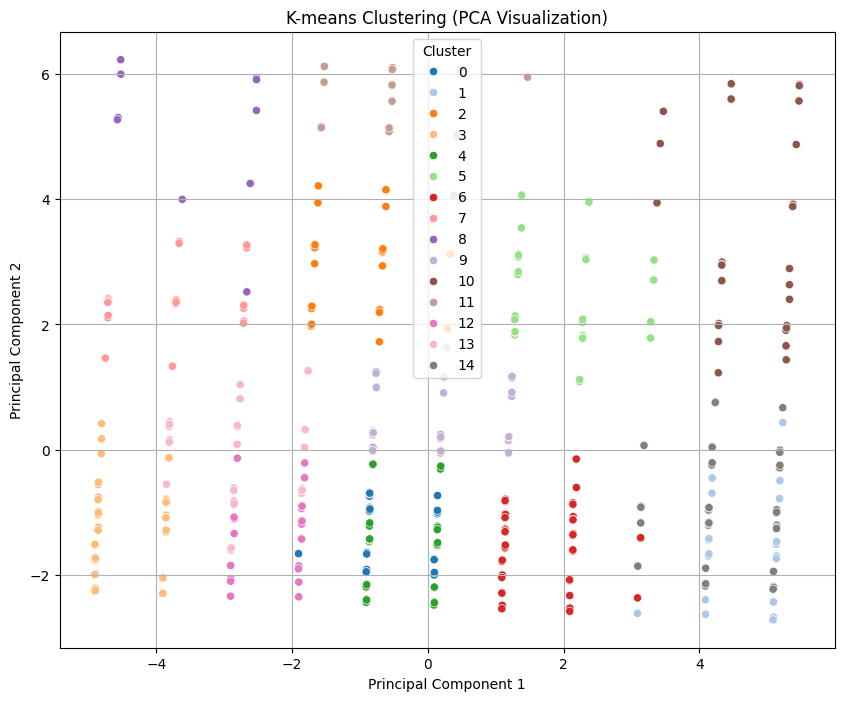

In [41]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=2)  
# X_standardized = (X - X.mean()) / X.std()
X_pca = pca.fit_transform(df)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=15, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(df)

df2['cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
plt.title('K-means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [42]:
#for i in range(15):
#    print(df2[df2['cluster'] == i].head(10).to_string())
df2[df2['cluster'] == 7].head(10)

,track_name,artist(s)_name,cluster
47,Believer,Imagine Dragons,7
52,Sweater Weather,The Neighbourhood,7
67,Daddy Issues,The Neighbourhood,7
128,Boy With Luv (feat. Halsey),"Halsey, BTS",7
173,Cruel Summer,Taylor Swift,7
185,Say You Won't Let Go,James Arthur,7
199,House Of Memories,Panic! At The Disco,7
205,Donï¿½ï¿½ï¿½t Bl,Taylor Swift,7
260,Bloody Mary,Lady Gaga,7
271,Don't Start Now,Dua Lipa,7


# 2. Determining the optimal number of clusters

## Elbow method

In [43]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

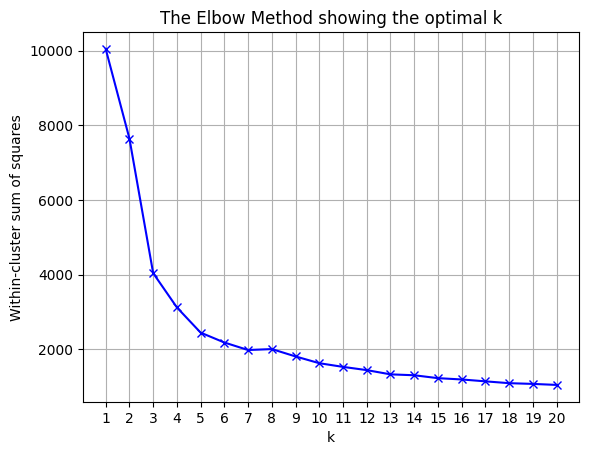

In [44]:
wcss_vec = count_wcss_scores(df, 20)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(x_ticks)
plt.grid(True)
plt.show()

In [45]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k,random_state=42)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

## Silhouette score

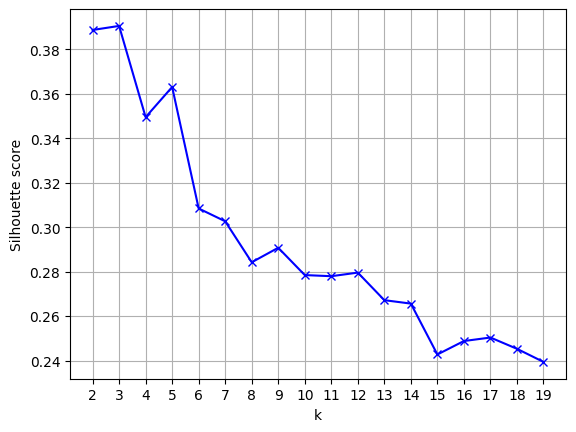

In [46]:
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()

## Davies-Bouldin score - DO NAPRAWY

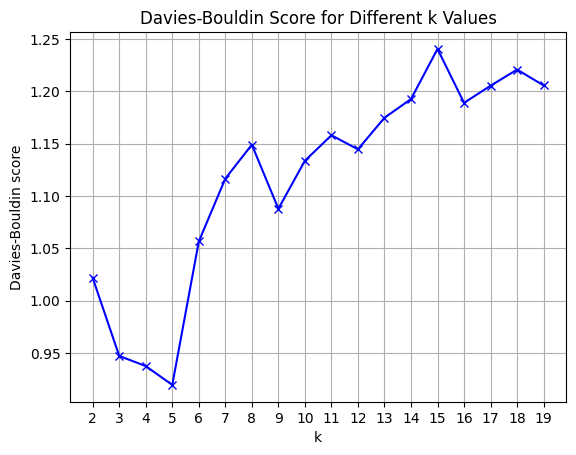

In [47]:
cluster_num_seq = range(2, 20)
#davies_bouldin_vec = count_clustering_scores(df, cluster_num_seq, KMeans, davies_bouldin_score)

davies_bouldin_vec = []
for k in cluster_num_seq:
    kmeans = KMeans(n_clusters=k,random_state=42)
    davies_bouldin_vec.append(davies_bouldin_score(df, kmeans.fit_predict(df)))


plt.plot(cluster_num_seq, davies_bouldin_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin Score for Different k Values')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()

## Caliński-Harabasz score

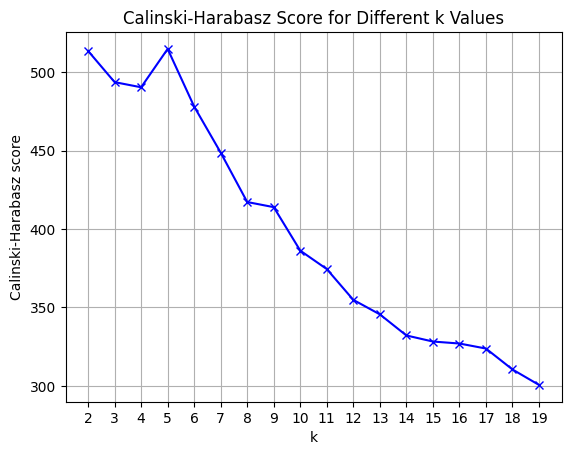

In [48]:
cluster_num_seq = range(2, 20)

calinski_harabasz_vec = count_clustering_scores(df, cluster_num_seq, KMeans, calinski_harabasz_score)

plt.plot(cluster_num_seq, calinski_harabasz_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz Score for Different k Values')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()

# Visualization for 5 clusters


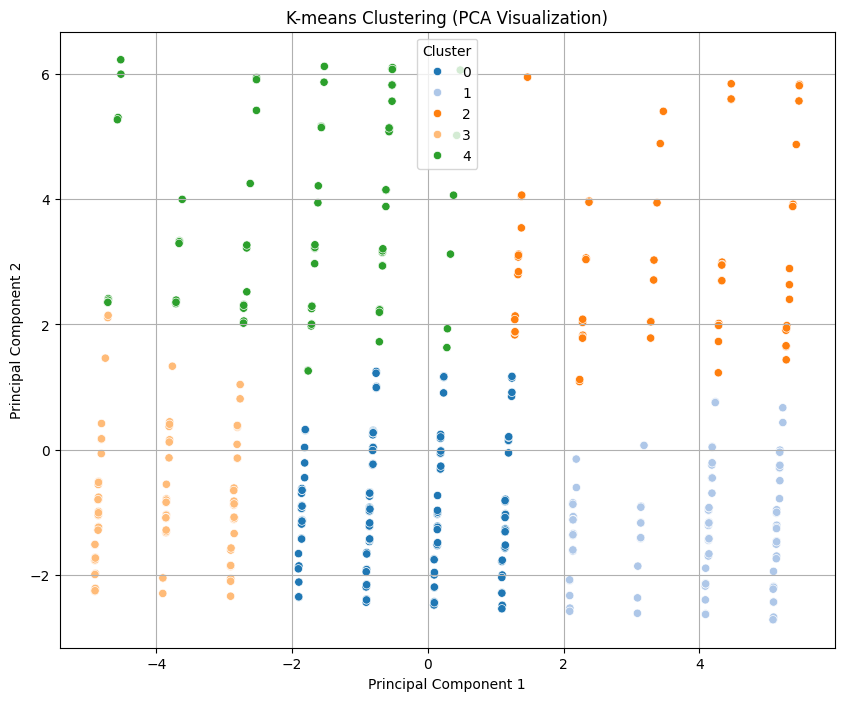

In [49]:
pca = PCA(n_components=2)  
# X_standardized = (X - X.mean()) / X.std()
X_pca = pca.fit_transform(df)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(df)

df2['cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
plt.title('K-means Clustering (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [50]:
df2[df2['cluster'] == 0].head(10)

,track_name,artist(s)_name,cluster
8,Levitating (feat. DaBaby),"Dua Lipa, DaBaby",0
9,DOGTOOTH,"Tyler, The Creator",0
12,Dos Oruguitas,Sebastian Yatra,0
13,Escapism. - Sped Up,"RAYE, 070 Shake",0
17,Major Distribution,"Drake, 21 Savage",0
22,Feliz Cumpleaï¿½ï¿½os Fe,Feid,0
24,The Astronaut,Jin,0
25,Boyfriends,Harry Styles,0
26,Fast Car,Luke Combs,0
28,Fin de Semana,"Oscar Maydon, Junior H",0
